## This botebook is to build machine learning classifier for predicting H-D-A or double chance.

Feature engineering idea is borrowed from paper:

>Regression models for forecasting goals and match results in association football, John Goddard (2005).

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
%matplotlib inline

## Feature Engineering

In [91]:
from football.datasets import load_EPL,load_Spain,load_France,load_Germany,load_Italy

f1, f2, f3, f4, f5 = load_EPL, load_Spain, load_France, load_Germany, load_Italy
# choose a league
load_league = f1

df1 = pd.concat([load_league('2002-2003').data, load_league('2003-2004').data], ignore_index=True)
df2 = pd.concat([load_league('2004-2005').data, load_league('2005-2006').data, \
                 load_league('2006-2007').data, load_league('2007-2008').data, \
                 load_league('2008-2009').data, load_league('2009-2010').data, \
                 load_league('2010-2011').data, load_league('2011-2012').data, \
                 load_league('2012-2013').data, load_league('2013-2014').data],\
                      ignore_index=True)

In [4]:
def FeatureEngineer(df1, df2, which_predictors = range(1, 28), real_predict=False):
    '''
    Return a dataframe of predictors given the raw dataset.

    Predictors:
    -------------------------------------------------------------------------
    x1:  average number of goals scored by team i, past 0~12 months
    x2:  average number of goals scored by team i, past 12~24 months
    x3:  average number of goals conceded by team i, past 0~12 months
    x4:  average number of goals conceded by team i, past 12~24 months

    x5:  average number of goals scored by team j, past 0~12 months
    x6:  average number of goals scored by team j, past 12~24 months
    x7:  average number of goals conceded by team j, past 0~12 months
    x8:  average number of goals conceded by team j, past 12~24 months
    -------------------------------------------------------------------------
    x9:  average match results team i, past 0~12 months
    x10: average match results team i, past 12~24 months
    x11: average match results team j, past 0~12 months
    x12: average match results team j, past 12~24 months
    (win=1, draw=0.5,lose=0)
    -------------------------------------------------------------------------
    x13: goals scored at home team i, recent 5 matches
    x14: goals scored away team i, recent 5 matches
    x15: goals conceded at home team i, recent 5 matches
    x16: goals conceded away team i, recent 5 matches

    x17: goals scored at home team j, recent 5 matches
    x18: goals scored away team j, recent 5 matches
    x19: goals conceded at home team j, recent 5 matches
    x20: goals conceded away team j, recent 5 matches
    -------------------------------------------------------------------------
    x21: match results at home team i, recent 5 matches
    x22: match results away team i, recent 5 matches
    x23: match results at home team j, recent 5 matches
    x24: match results away team j, recent 5 matches
    (win=1, draw=0.5,lose=0)
    -------------------------------------------------------------------------

    x25: home win odds
    x26: draw odds
    x27: away win odds

    -------------------------------------------------------------------------

    Parameters:

    df1: pd.DataFrame, [season1, season2]
    df2: pd.DataFrame, [season3, season4,...]
    which_predictors: list, decide which predictors to use, e.g. range(1, 11) + [25,26,27]
    real_predict: True, False. If True, for real pre-match betting, upcoming matches' data are NaN

    '''

    N_past = len(df1.Date)
    N_train = len(df2.Date)

    # FTR is not known for real pre-match betting
    if real_predict:
        #convert FTR to match points
        valH, valA = {'H':1.0, 'D':0.5, 'A':0.0}, {'H':0.0, 'D':0.5, 'A':1.0}
        df1['FTRH'] = [valH[res] for res in df1.FTR]
        df1['FTRA'] = [valA[res] for res in df1.FTR]
        #df2.fillna(0)
        dataset = pd.concat([df1,df2], ignore_index=True)[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'FTRH', 'FTRA']]
    # just doing researching on historic dataset, results are all known
    else:
        dataset = pd.concat([df1,df2], ignore_index=True)[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
        #convert FTR to match points
        valH, valA = {'H':1.0, 'D':0.5, 'A':0.0}, {'H':0.0, 'D':0.5, 'A':1.0}
        dataset['FTRH'] = [valH[res] for res in dataset.FTR]
        dataset['FTRA'] = [valA[res] for res in dataset.FTR]

    all_predictors = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14', \
                     'x15','x16','x17','x18','x19','x20','x21','x22','x23','x24', 'x25', 'x26', 'x27']
    use_predictors = [u for (i,u) in enumerate(all_predictors) if (i+1) in which_predictors]

    predictors = \
    pd.DataFrame([[0.0]*len(use_predictors)]*N_train, dtype=float, \
             columns=use_predictors \
            )

    print 'Feature Engineering Task(part by part)\n\nPart 1 Loading.'
    #-------------------------------------------------------------------------------------------------------------

    if 'x1' in use_predictors:
        #x1:  average number of goals scored by team i, past 0~12 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTHG'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTAG'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()) / 38.0
        predictors['x1'] = [f(i) for i in range(N_train)]
    if 'x2' in use_predictors:
        #x2:  average number of goals scored by team i, past 12~24 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTHG'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTAG'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()) / 38.0
        predictors['x2'] = [f(i) for i in range(N_train)]
    if 'x3' in use_predictors:
        #x3:  average number of goals conceded by team i, past 0~12 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTAG'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTHG'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()) / 38.0
        predictors['x3'] = [f(i) for i in range(N_train)]
    if 'x4' in use_predictors:
        #x4:  average number of goals conceded by team i, past 12~24 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTAG'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTHG'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()) / 38.0
        predictors['x4'] = [f(i) for i in range(N_train)]

    if 'x5' in use_predictors:
        #x5:  average number of goals scored by team j, past 0~12 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTHG'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTAG'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()) / 38.0
        predictors['x5'] = [f(i) for i in range(N_train)]
    if 'x6' in use_predictors:
        #x6:  average number of goals scored by team j, past 12~24 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTHG'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTAG'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()) / 38.0
        predictors['x6'] = [f(i) for i in range(N_train)]
    if 'x7' in use_predictors:
        #x7:  average number of goals conceded by team j, past 0~12 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTAG'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTHG'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()) / 38.0
        predictors['x7'] = [f(i) for i in range(N_train)]
    if 'x8' in use_predictors:
        #x8:  average number of goals conceded by team j, past 12~24 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTAG'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTHG'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()) / 38.0
        predictors['x8'] = [f(i) for i in range(N_train)]

    #-------------------------------------------------------------------------------------------------------------
    print 'Part 2 Loading.'

    if 'x9' in use_predictors:
        #x9:  average match results team i, past 0~12 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTRH'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTRA'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()) / 38.0
        predictors['x9'] = [f(i) for i in range(N_train)]
    if 'x10' in use_predictors:
        #x10: average match results team i, past 12~24 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTRH'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTRA'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()) / 38.0
        predictors['x10'] = [f(i) for i in range(N_train)]
    if 'x11' in use_predictors:
        #x11: average match results team j, past 0~12 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTRH'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'FTRA'][dataset.loc[(i/10*10+N_past-380):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()) / 38.0
        predictors['x11'] = [f(i) for i in range(N_train)]
    if 'x12' in use_predictors:
        #x12: average match results team j, past 12~24 months
        f = lambda i: \
        ((dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTRH'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum() + \
        (dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'FTRA'][dataset.loc[(i/10*10+N_past-760):(i/10*10+N_past-381), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()) / 38.0
        predictors['x12'] = [f(i) for i in range(N_train)]
        #(win=1, draw=0.5,lose=0)

    #-------------------------------------------------------------------------------------------------------------
    print 'Part 3 Loading.'

    if 'x13' in use_predictors:
        #x13: goals scored at home team i, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTHG'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()
        predictors['x13'] = [f(i) for i in range(N_train)]
    if 'x14' in use_predictors:
        #x14: goals scored away, team i, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTAG'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()
        predictors['x14'] = [f(i) for i in range(N_train)]
    if 'x15' in use_predictors:
        #x15: goals conceded at home team i, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTAG'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()
        predictors['x15'] = [f(i) for i in range(N_train)]
    if 'x16' in use_predictors:
        #x16: goals conceded away, team i, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTHG'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()
        predictors['x16'] = [f(i) for i in range(N_train)]

    if 'x17' in use_predictors:
        #x17: goals scored at home team j, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTHG'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()
        predictors['x17'] = [f(i) for i in range(N_train)]
    if 'x18' in use_predictors:
        #x18: goals scored away team j, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTAG'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()
        predictors['x18'] = [f(i) for i in range(N_train)]
    if 'x19' in use_predictors:
        #x19: goals conceded at home team j, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTAG'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()
        predictors['x19'] = [f(i) for i in range(N_train)]
    if 'x20' in use_predictors:
        #x20: goals conceded away team j, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTHG'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()
        predictors['x20'] = [f(i) for i in range(N_train)]

    #-------------------------------------------------------------------------------------------------------------
    print 'Part 4 Loading.'

    if 'x21' in use_predictors:
        #x21: match results at home team i, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTRH'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()
        predictors['x21'] = [f(i) for i in range(N_train)]
    if 'x22' in use_predictors:
        #x22: match results away, team i, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTRA'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'HomeTeam']]).sum()
        predictors['x22'] = [f(i) for i in range(N_train)]
    if 'x23' in use_predictors:
        #x23: match results at home team j, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTRH'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'HomeTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()
        predictors['x23'] = [f(i) for i in range(N_train)]
    if 'x24' in use_predictors:
        #x24: match results away, team j, recent 5 matches
        f = lambda i: \
        (dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'FTRA'][dataset.loc[(i/10*10+N_past-5):(i/10*10+N_past-1), 'AwayTeam']==dataset.loc[i+N_past, 'AwayTeam']]).sum()
        predictors['x24'] = [f(i) for i in range(N_train)]
        #(win=1, draw=0.5,lose=0)

    #-------------------------------------------------------------------------------------------------------------
    print 'Part 5 Loading.'

    #x25: win-draw-win odds for each match, on train dataset
    if 'x25' in use_predictors:
        # assign a col to another, the indexes of these two columns must be identical
        predictors['x25'] = df2.reset_index(drop=True)['B365H']
    if 'x26' in use_predictors:
        predictors['x26'] = df2.reset_index(drop=True)['B365D']
    if 'x27' in use_predictors:
        predictors['x27'] = df2.reset_index(drop=True)['B365A']


    #-------------------------------------------------------------------------------------------------------------
    print '\nFinishing.'

    return predictors



def ResponseEngineer(dataset, which=0):
    '''
    Return a list of response.

    Response:

    which=0, default
    y = 0, home win
    y = 1, draw
    y = 2, away win

    Other types: see [val0, val1, val2, val3]

    --------------------------------------------
    Parameters:

    dataset: pd.DataFrame, training df2
    which: int, 0~3

    '''
    val0 = {'H':0, 'D':1, 'A':2}
    val1 = {'H':0, 'D':1, 'A':1}
    val2 = {'D':0, 'H':1, 'A':1}
    val3 = {'A':0, 'H':1, 'D':1}

    # choose a type from [val0, val1, val2, val3]
    val = [val0, val1, val2, val3][which]
    return [val[res] for res in dataset.FTR]

In [92]:
# e.g. x1, x2,..., x24
X = FeatureEngineer(df1, df2, which_predictors=range(1,25), real_predict=False)
#X = FeatureEngineer(df1, df2, which_predictors=[25, 27], real_predict=False)

Feature Engineering Task(part by part)

Part 1 Loading.
Part 2 Loading.
Part 3 Loading.
Part 4 Loading.
Part 5 Loading.

Finishing.


In [93]:
y = ResponseEngineer(df2, which=2)

In [94]:
X.loc[8:12, ]

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24
8,1.763158,1.789474,0.789474,1.000000,1.684211,1.947368,0.921053,0.894737,0.723684,0.631579,...,0,0,0,0,0,0,1,0.0,0.0,0
9,1.184211,1.263158,1.500000,1.289474,1.921053,2.236842,0.684211,1.105263,0.394737,0.552632,...,0,5,0,0,0,0,0,0.0,0.0,0
10,1.131579,1.105263,1.289474,1.236842,1.736842,1.763158,0.763158,0.973684,0.486842,0.486842,...,0,1,1,0,0,0,0,0.5,1.0,0
11,1.368421,1.131579,1.368421,1.473684,1.210526,0.052632,1.421053,0.026316,0.513158,0.460526,...,0,0,1,0,1,0,0,0.0,0.5,0
12,0.026316,0.000000,0.026316,0.000000,1.184211,1.236842,1.552632,1.289474,0.013158,0.000000,...,0,1,1,0,4,0,0,0.5,0.0,0


In [95]:
y[0:10]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 1]

### take a look at the odds with match outcomes

Number of H,D,A: 89 61 51


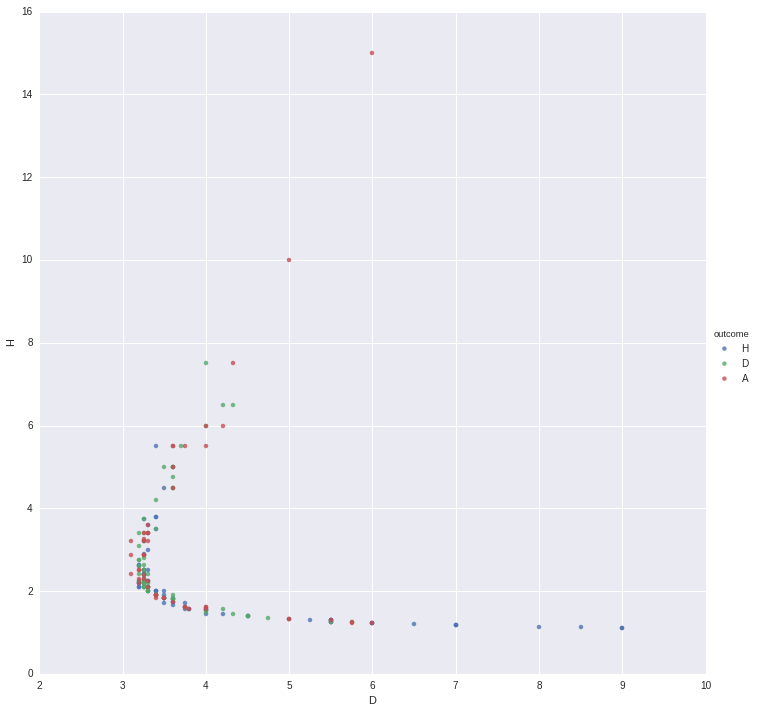

In [407]:
# prob = 1/odds
H = [u for u in df2.ix[0:200, 'B365H'].values]
D = [u for u in df2.ix[0:200, 'B365D'].values]
A = [u for u in df2.ix[0:200, 'B365A'].values]
outcome = df2.ix[0:200, 'FTR']
print 'Number of H,D,A:', (outcome=='H').sum(), (outcome=='D').sum(), (outcome=='A').sum()

data = pd.DataFrame({'H': H, \
                     'D': D, \
                     'A': A, \
                     'outcome': outcome}, \
                    columns=['H','D','A','outcome'] \
                   )

sns.set_style('darkgrid')
sns.lmplot("D", "H", hue="outcome", data=data, fit_reg=False, size=10)

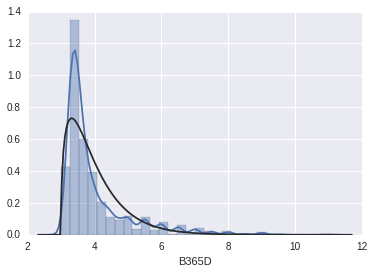

In [408]:
from scipy import stats
sns.distplot(df2['B365D'], kde=True, fit=stats.gamma, bins=30)

### Team Performance  at Piecewise Odds

In [466]:
def piecewise(df, team=None, play_side='home', season=['2013-2014'], lower=1.0, upper=1.5, check='B365H'):

    '''

    Check team(s)'s historic performance according to
    specific piecewise odds.

    -----------
    Parameters:

    df: pd.DataFrame, single season or concated several seasons
    team: list, defaul All Teams, team that want to check
    season: list, contains the season(s) to check
    play_side: str, 'home' or 'away', check this team's performance at home or away
    lower: float, lower bound of the odds, according to check=
    upper: float, upper bound of the odds, according to check=
    check: str, 'B365H', 'B365D' or 'B365A', which odds to be piecewise, within (lower, upper)

    '''

    # piecewise_df: all matches at piecewise odds
    piecewise_df = df.loc[ ((df[check]>lower) & (df[check]<upper)), ['Season', 'Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR','B365H','B365D','B365A']]
    piecewise_df.reset_index(drop=True, inplace=True)

    # focus on team(s) playing at home
    if play_side=='home':
        df_w = piecewise_df[piecewise_df['FTR']=='H']
        df_w.reset_index(drop=True, inplace=True)
        df_d = piecewise_df[piecewise_df['FTR']=='D']
        df_d.reset_index(drop=True, inplace=True)
        df_l = piecewise_df[piecewise_df['FTR']=='A']
        df_l.reset_index(drop=True, inplace=True)

    # focus on team(s) playing away
    elif play_side=='away':
        # split df: normal, abnormal
        df_w = piecewise_df[piecewise_df['FTR']=='A']
        df_w.reset_index(drop=True, inplace=True)
        df_d = piecewise_df[piecewise_df['FTR']=='D']
        df_d.reset_index(drop=True, inplace=True)
        df_l = piecewise_df[piecewise_df['FTR']=='H']
        df_l.reset_index(drop=True, inplace=True)

    else:
        raise ValueError('Wrong play_side')

    # whether focus on a single team's performance
    if team:
        if any( [(t not in df.HomeTeam.values) for t in team] ):
            raise ValueError('Invalid Input: team')
        # focus on a team's performance
        if play_side=='home':
            col='HomeTeam'
        else:
            col='AwayTeam'
        df_w_team = df_w[ np.array([(t in team) for t in df_w[col]]) & np.array([s in season for s in df_w['Season']]) ]
        df_d_team = df_d[ np.array([(t in team) for t in df_d[col]]) & np.array([s in season for s in df_d['Season']]) ]
        df_l_team = df_l[ np.array([(t in team) for t in df_l[col]]) & np.array([s in season for s in df_l['Season']]) ]

    else:
        # all teams' performance
        df_w_team = df_w[ np.array([s in season for s in df_w['Season']]) ]
        df_d_team = df_d[ np.array([s in season for s in df_d['Season']]) ]
        df_l_team = df_l[ np.array([s in season for s in df_l['Season']]) ]

    df_w_team.reset_index(drop=True, inplace=True)
    df_d_team.reset_index(drop=True, inplace=True)
    df_l_team.reset_index(drop=True, inplace=True)
    return df_w_team, df_d_team, df_l_team

In [433]:
load_league = load_EPL
df = pd.concat([load_league('2010-2011').data, load_league('2011-2012').data, \
                load_league('2012-2013').data, load_league('2013-2014').data, \
                load_league('2014-2015').data, load_league('2015-2016').data], ignore_index=True)

In [470]:
df_win, df_draw, df_lose = \
piecewise(df, team=['West Ham', 'Crystal Palace'], play_side='away', season=['2014-2015'], \
          lower=1.0, upper=10.0, check='B365A')

df_win

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A
0,2014-2015,2014-08-23,Crystal Palace,West Ham,1,3,A,2.50,3.30,3.10
1,2014-2015,2014-09-21,Everton,Crystal Palace,2,3,A,1.40,5.00,9.00
2,2014-2015,2014-10-18,Burnley,West Ham,1,3,A,2.80,3.40,2.70
3,2014-2015,2014-12-02,West Brom,West Ham,1,2,A,2.50,3.40,3.00
4,2014-2015,2015-01-17,Burnley,Crystal Palace,2,3,A,2.55,3.25,3.10
5,2014-2015,2015-02-07,Leicester,Crystal Palace,0,1,A,2.40,3.30,3.25
6,2014-2015,2015-02-28,West Ham,Crystal Palace,1,3,A,2.15,3.40,3.75
7,2014-2015,2015-03-21,Stoke,Crystal Palace,1,2,A,2.10,3.30,3.50
8,2014-2015,2015-04-11,Sunderland,Crystal Palace,1,4,A,2.90,3.20,2.70
9,2014-2015,2015-05-16,Liverpool,Crystal Palace,1,3,A,1.45,4.75,8.00


In [471]:
df_draw

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A
0,2014-2015,2014-08-30,Newcastle,Crystal Palace,3,3,D,1.75,3.75,5.25
1,2014-2015,2014-09-15,Hull,West Ham,2,2,D,2.15,3.40,3.75
2,2014-2015,2014-10-25,West Brom,Crystal Palace,2,2,D,1.91,3.60,4.50
3,2014-2015,2014-11-01,Stoke,West Ham,2,2,D,2.38,3.40,3.25
4,2014-2015,2014-11-29,Swansea,Crystal Palace,1,1,D,1.80,3.75,5.00
5,2014-2015,2014-12-06,Tottenham,Crystal Palace,0,0,D,1.60,4.20,6.00
6,2014-2015,2014-12-13,Sunderland,West Ham,1,1,D,2.95,3.40,2.55
7,2014-2015,2014-12-28,QPR,Crystal Palace,0,0,D,2.38,3.40,3.25
8,2014-2015,2015-01-01,Aston Villa,Crystal Palace,0,0,D,2.40,3.30,3.30
9,2014-2015,2015-01-10,Swansea,West Ham,1,1,D,2.25,3.50,3.40


In [472]:
df_lose

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A
0,2014-2015,2014-09-27,Man United,West Ham,2,1,H,1.40,5.5,8.00
1,2014-2015,2014-10-04,Hull,Crystal Palace,2,0,H,2.10,3.5,3.80
2,2014-2015,2014-11-22,Everton,West Ham,2,1,H,1.85,3.8,4.50
3,2014-2015,2015-01-31,Liverpool,West Ham,2,0,H,1.67,4.0,5.75
4,2014-2015,2015-03-03,Southampton,Crystal Palace,1,0,H,1.70,3.8,5.75
5,2014-2015,2015-03-14,Arsenal,West Ham,3,0,H,1.40,5.0,9.00
6,2014-2015,2015-04-04,Leicester,West Ham,2,1,H,2.38,3.3,3.10
7,2014-2015,2015-05-09,Aston Villa,West Ham,1,0,H,1.91,3.7,4.33
8,2014-2015,2015-05-24,Newcastle,West Ham,2,0,H,1.83,4.0,4.33


In [478]:
# bet i=0,1,2 -> H,D,A
side = 'away'
i = 1
if side=='home':
    bet_on = ( df_win['B365H'], df_draw['B365D'], df_lose['B365A'] )[i]
elif side=='away':
    bet_on = ( df_lose['B365H'], df_draw['B365D'], df_win['B365A'] )[i]
print '\nProfit if place 1.0 pound for each match whithin above piecewise odds: '
print bet_on.sum()-len(df_win['Date'])-len(df_draw['Date'])-len(df_lose['Date'])
print 


Profit if place 1.0 pound for each match whithin above piecewise odds: 
14.8



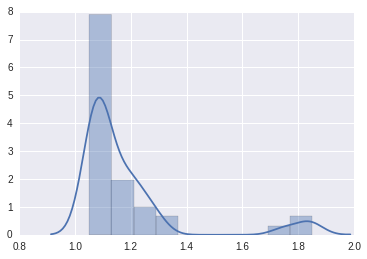

In [997]:
sns.distplot( df.ix[(df.HomeTeam.values==team), 'B365H'].values[38:76], bins=10 )

## Training & Validation

In [7]:
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error

### first classifier: a simple SVM

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
# Set the parameters by cross-validation
tuned_parameters = \
[{'kernel': ['rbf'], 'gamma': np.logspace(-4, 3, 8), 'C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}, \
{'kernel': ['linear'], 'C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}, \
{'kernel':['poly'], 'degree':[1,2,3,4,5,6,7,8,9,10], 'C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}]

scores = ['recall', 'precision']

for score in scores:
    print "# Tuning hyper-parameters for %s" % score + '\n'

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(X_train, y_train)

    print "Best parameters set found on development set:"
    print clf.best_params_
    print '\n'
    print "Grid scores on development set:"
    print '\n'
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print '\n'

    print "Detailed classification report:"
    print '\n'
    print "The model is trained on the full development set."
    print "The scores are computed on the full evaluation set."
    print '\n'
    # prediction on validation dataset
    y_true, y_pred = y_test, clf.predict(X_test)
    print 'validation dataset'
    print classification_report(y_true, y_pred)
    print confusion_matrix(y_true, y_pred)
    print '\n'
    # fit on train dataset
    y_true, y_pred = y_train, clf.predict(X_train)
    print 'train dataset'
    print classification_report(y_true, y_pred)
    print confusion_matrix(y_true, y_pred)
    print '\n'

# Tuning hyper-parameters for recall

Best parameters set found on development set:
{'kernel': 'linear', 'C': 0.3}


Grid scores on development set:


0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.001, 'gamma': 0.0001}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.001, 'gamma': 0.001}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.001, 'gamma': 0.01}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.001, 'gamma': 0.10000000000000001}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.001, 'gamma': 1.0}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.001, 'gamma': 10.0}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.001, 'gamma': 100.0}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.001, 'gamma': 1000.0}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.003, 'gamma': 0.0001}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.003, 'gamma': 0.001}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.003, 'gamma': 0.01}
0.457 (+/-0.003) for {'kernel': 'rbf', 'C': 0.003, 'gamma': 0.10000000000000001}
0.457 (+/-0.003) fo

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
# parameters = {'C':[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
# clf = LinearSVC(penalty='l2', loss='l2', dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None)
parameters = {'kernel': ['rbf'], 'gamma': np.logspace(-4, 3, 8), 'C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
clf = SVC()

# try to improve recall
gs = GridSearchCV(clf, param_grid=parameters, cv=10, scoring='precision')
gs.fit(X_train, y_train)
#print gs.grid_scores_
print gs.best_params_, gs.best_score_

# prediction on validation dataset
y_true, y_pred = y_test, gs.predict(X_test)
print 'validation dataset'
print classification_report(y_true, y_pred)
print confusion_matrix(y_true, y_pred)
print '\n'
# fit on train dataset
y_true, y_pred = y_train, gs.predict(X_train)
print 'train dataset'
print classification_report(y_true, y_pred)
print confusion_matrix(y_true, y_pred)
print '\n'

print \
'''
Precision and Recall:

When a search engine returns 30 pages only 20 of which were relevant while failing 
to return 40 additional relevant pages, its precision is 20/30 = 2/3 while its recall is 20/60 = 1/3.
'''

{'kernel': 'rbf', 'C': 3.0, 'gamma': 1.0} 0.762687001819
validation dataset
             precision    recall  f1-score   support

          0       0.24      0.10      0.14        42
          1       0.82      0.93      0.87       186

avg / total       0.71      0.78      0.74       228

[[  4  38]
 [ 13 173]]


train dataset
             precision    recall  f1-score   support

          0       0.98      0.84      0.90       219
          1       0.95      0.99      0.97       693

avg / total       0.96      0.96      0.96       912

[[184  35]
 [  4 689]]



Precision and Recall:

When a search engine returns 30 pages only 20 of which were relevant while failing 
to return 40 additional relevant pages, its precision is 20/30 = 2/3 while its recall is 20/60 = 1/3.



## Deeper

### unbalanced labels problem, home win 50%, draw 20%, away win 30%

In [96]:
import random
#from sklearn.cross_validation import StratifiedShuffleSplit

def balance_sample(X, y, proportion={0:0.5, 1:0.5}):
    '''
    Change the proportion of samples in different groups.
    -----------
    Parameters:

    X: pd.DataFrame, original dataset
    y: list-like, original response
    proportion: dict, e.g. {0:0.5, 1:0.5}, {0:0.4, 1:0.2, 2:0.2}
    specify the proportion of each group

    '''
    n_cat = len(proportion.keys())
    n_samples = len(y)
    if n_cat==2:
        # the prop of each cat in the sample
        prop_0 = (np.array(y)==0).mean()
        n_0 = (np.array(y)==0).sum()
        prop_1 = (np.array(y)==1).mean()
        n_1 = (np.array(y)==1).sum()

        # split dataset by response
        X_0 = X[np.array(y)==0]
        X_0.reset_index(drop=True, inplace=True)
        y_0 = [0]*n_0
        X_1 = X[np.array(y)==1]
        X_1.reset_index(drop=True, inplace=True)
        y_1 = [1]*(n_samples-n_0)

        # want to cut the prop to be less than in the sample
        if proportion[0] < prop_0:
            cut = int( (n_0-proportion[0]*n_samples)/(1-proportion[0]) )
            n_new_0 = n_0 - cut
            index = random.sample( set(range(n_0)), n_new_0 )
            X_new_0 = X_0.ix[index, :]
            X_new_0.reset_index(drop=True, inplace=True)
            _X = pd.concat([X_new_0, X_1], ignore_index=True)
            _y = [0]*n_new_0 + [1]*n_1
            print 'cutting off label 0: %d-->%d\n'%(n_0, n_new_0)
        elif proportion[0] > prop_0:
            cut = int( (n_1-proportion[1]*n_samples)/(1-proportion[1]) )
            n_new_1 = n_1 - cut
            index = random.sample( set(range(n_1)), n_new_1 )
            X_new_1 = X_1.ix[index, :]
            X_new_1.reset_index(drop=True, inplace=True)
            _X = pd.concat([X_new_1, X_0], ignore_index=True)
            _y = [1]*n_new_1 + [0]*n_0
            print 'cutting off label 1: %d-->%d\n'%(n_1, n_new_1)
        print 'original proportion:\n0:%.2f, 1:%.2f'%(prop_0, prop_1)
        print 'modify to proportion:\n0:%.2f, 1:%.2f'%(proportion[0], proportion[1])
        print '\ncurrent total samples: %d' %len(_y)
    elif n_cat==3:
        pass

    else:
        pass

    return _X,_y

In [97]:
_X,_y = balance_sample(X, y, proportion={0:0.35, 1:0.65})

cutting off label 1: 2832-->1798

original proportion:
0:0.25, 1:0.75
modify to proportion:
0:0.35, 1:0.65

current total samples: 2766


### try ensemble methods
>improving the precision of recognizing Draw games to 40%+, since odds for draw normally 3.0+

In [118]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer

In [141]:
# which =  0.HDA, 1.H DA, 2.D HA, 3.A HD
# y = ResponseEngineer(df2, which=2)
#
# X['x25_2'] = [round(u**2,2) for u in X['x25'].values]
# X['x27_2'] = [round(u**2,2) for u in X['x27'].values]
# X['x25_3'] = [round(u**3,2) for u in X['x25'].values]
# X['x27_3'] = [round(u**3,2) for u in X['x27'].values]
# X['x25_x27'] = [round(u*v,2) for u,v in zip(X['x25'].values, X['x27'].values)]

#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_test, y_train, y_test = train_test_split(_X, _y, train_size=0.8, random_state=True)
print 'percetage of D in validation set: ', (np.array(y_test)==0).mean().round(2), '\n'

# unbalanced sample. 0 draw : 1 HA = 0.3 : 0.7
#sample_weight = np.array([0.5 if i == 0 else 1 for i in y_train])


#gs = LogisticRegression(C=1.0)
#gs = SVC(C=1.0, gamma=0.3, kernel='rbf', class_weight={0:2.0, 1:1.0})
#gs = BaggingClassifier(base_estimator=SVC(C=1.0, gamma=0.3, kernel='rbf', class_weight={0:1.6, 1:1.0}), n_estimators=50)
#gs = BaggingClassifier(base_estimator=SVC(C=1.0, gamma=0.3, kernel='poly', degree=3, class_weight={0:1.6, 1:1.0}), n_estimators=50)
#gs = AdaBoostClassifier(base_estimator=SVC(C=1.0, gamma=1.0, kernel='rbf', class_weight={0:1.6, 1:1.0}), n_estimators=5, algorithm='SAMME')
#gs = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=5), n_estimators=50)
#gs = GradientBoostingClassifier(n_estimators=500, learning_rate=0.5)
#gs = AdaBoostClassifier(base_estimator=SGDClassifier(class_weight={0:1.6, 1:1.0}), n_estimators=500, algorithm='SAMME')
#gs = BaggingClassifier(LogisticRegression(C=1.0), n_estimators=100)


#clf = RandomForestClassifier(n_estimators=200, max_features=15, max_depth=None, \
#                            min_samples_split=2, bootstrap=True, class_weight={0:1.5, 1:1.0})

# define a scoring function, precision of draw games
def precision_of_draw(ground_truth, predictions):
    n = (np.array(predictions)==0).sum()
    c = len(ground_truth) - (np.array(ground_truth) | np.array(predictions)).sum()
    return c/(n+0.0)
score = make_scorer(precision_of_draw, greater_is_better=True)

clf = RandomForestClassifier(min_samples_split=2, bootstrap=True)
gs = GridSearchCV(clf, \
                  param_grid={'n_estimators':[50,100,200], 'max_features':[5,8,11,15], \
                                    'class_weight':[{0:1.0, 1:1.0}, {0:1.5, 1:1.0}, {0:1.0, 1:1.5}]}, \
                  cv=5, scoring=score)

#print 'cross validation score:', cross_val_score(estimator=gs, X=X_train, y=y_train, scoring='precision', cv=5)
#print 
gs.fit(X_train, y_train)
#gs.fit(X_train, y_train, sample_weight=sample_weight)

# prediction on validation dataset
y_true, y_pred = y_test, gs.predict(X_test)
print 'validation dataset'
print classification_report(y_true, y_pred)
print confusion_matrix(y_true, y_pred)
print '\n'
# fit on train dataset
y_true, y_pred = y_train, gs.predict(X_train)
print 'train dataset'
print classification_report(y_true, y_pred)
print confusion_matrix(y_true, y_pred)
print '\n'

#print 'predict: ', gs.predict(test_X)

percetage of D in validation set:  0.36 

validation dataset
             precision    recall  f1-score   support

          0       0.38      0.17      0.23       198
          1       0.65      0.85      0.74       356

avg / total       0.55      0.61      0.56       554

[[ 33 165]
 [ 53 303]]


train dataset
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       770
          1       1.00      1.00      1.00      1442

avg / total       1.00      1.00      1.00      2212

[[ 770    0]
 [   0 1442]]




In [142]:
for params, mean_score, scores in gs.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))

0.372 (+/-0.099) for {'max_features': 5, 'n_estimators': 50, 'class_weight': {0: 1.0, 1: 1.0}}
0.424 (+/-0.108) for {'max_features': 5, 'n_estimators': 100, 'class_weight': {0: 1.0, 1: 1.0}}
0.365 (+/-0.053) for {'max_features': 5, 'n_estimators': 200, 'class_weight': {0: 1.0, 1: 1.0}}
0.389 (+/-0.152) for {'max_features': 8, 'n_estimators': 50, 'class_weight': {0: 1.0, 1: 1.0}}
0.370 (+/-0.143) for {'max_features': 8, 'n_estimators': 100, 'class_weight': {0: 1.0, 1: 1.0}}
0.372 (+/-0.106) for {'max_features': 8, 'n_estimators': 200, 'class_weight': {0: 1.0, 1: 1.0}}
0.356 (+/-0.034) for {'max_features': 11, 'n_estimators': 50, 'class_weight': {0: 1.0, 1: 1.0}}
0.385 (+/-0.106) for {'max_features': 11, 'n_estimators': 100, 'class_weight': {0: 1.0, 1: 1.0}}
0.382 (+/-0.093) for {'max_features': 11, 'n_estimators': 200, 'class_weight': {0: 1.0, 1: 1.0}}
0.395 (+/-0.102) for {'max_features': 15, 'n_estimators': 50, 'class_weight': {0: 1.0, 1: 1.0}}
0.387 (+/-0.081) for {'max_features': 15

In [143]:
gs.best_params_

{'class_weight': {0: 1.0, 1: 1.0}, 'max_features': 5, 'n_estimators': 100}

## Out-of-sample test

In [110]:
# 10 new matches, real_predict=True
test_df1 = pd.concat([load_league('2012-2013').data, load_league('2013-2014').data, load_league('2014-2015').data[0:109]], ignore_index=True)
test_df2 = load_league('2015-2016').data[110:]

In [101]:
# new full season, real_predict=False
test_df1 = pd.concat([load_league('2012-2013').data, load_league('2013-2014').data], ignore_index=True)
test_df2 = pd.concat([load_league('2014-2015').data, load_league('2015-2016').data], ignore_index=True)
#test_df2 = load_league('2014-2015').data

In [102]:
# notice the selection of predictors
test_X = FeatureEngineer(test_df1, test_df2, which_predictors=range(1, 25), real_predict=False)

Feature Engineering Task(part by part)

Part 1 Loading.
Part 2 Loading.
Part 3 Loading.
Part 4 Loading.
Part 5 Loading.

Finishing.


In [144]:
# which=2: find Draw games

real_predict = False

if real_predict:
    # real_predict
    print 'real predict: ', gs.predict(test_X)
else:
    # test
    test_y = ResponseEngineer(test_df2, which=2)

In [145]:
# 10 matches each round
r = 0

if r == 0:# all matches
    group_test_X = test_X
    group_test_y = test_y
#     home_low, home_up = 0, 100
#     draw_low, draw_up = 0, 100
#     away_low, away_up = 0, 100
#     group_test_X = test_X.ix[:, 0:24][((home_low<test_X['x25'].values) & (test_X['x25'].values<home_up)) | ((away_low<test_X['x27'].values) & (test_X['x27'].values<away_up))]
#     group_test_y = np.array(test_y)[((home_low<test_X['x25'].values) & (test_X['x25'].values<home_up)) | ((away_low<test_X['x27'].values) & (test_X['x27'].values<away_up))]
else:# 10 matches
    group_test_X = test_X.ix[range(10*(r-1), 10*r), ]
    group_test_y = test_y[10*(r-1):(10*r)]

clf_accuracy = (gs.predict(group_test_X) == group_test_y).mean()
print '(Out-of-sample) Classification accuracy: ', clf_accuracy
print '----------------------------------------------------------'
print classification_report(group_test_y, gs.predict(group_test_X))
print '----------------------------------------------------------'
print confusion_matrix(group_test_y, gs.predict(group_test_X))
print '----------------------------------------------------------'

(Out-of-sample) Classification accuracy:  0.69
----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.25      0.11      0.15       126
          1       0.75      0.89      0.81       374

avg / total       0.62      0.69      0.64       500

----------------------------------------------------------
[[ 14 112]
 [ 43 331]]
----------------------------------------------------------


In [79]:
# put 1 stake on each match equally
n_D, n_HA = 21,35
stake = 110
print n_D*4.2+n_HA*1.2-stake
print n_D*2.3+n_HA*1.7-stake

20.2
-2.2


ignore from below this line...
### --------------------------------------------------------------------------------------------------------------------------------------------------

In [46]:
trans = {0:'H', 1:'D', 2:'A'}
test_report = pd.DataFrame({'Date':test_df2.Date, \
                       'HomeTeam':test_df2.HomeTeam, \
                       'AwayTeam':test_df2.AwayTeam, \
                       'True Outcome':test_df2.FTR.tolist(), \
                       'Predicted Outcome': [trans[res] for res in gs.predict(test_X)], \
                       'H':test_df2.B365H,\
                       'D':test_df2.B365D,\
                       'A':test_df2.B365A\
                      }, columns=['Date', 'HomeTeam', 'AwayTeam', 'True Outcome', 'Predicted Outcome', 'H', 'D', 'A'])


In [3235]:
test_report.ix[0:10, ]

NameError: name 'test_report' is not defined

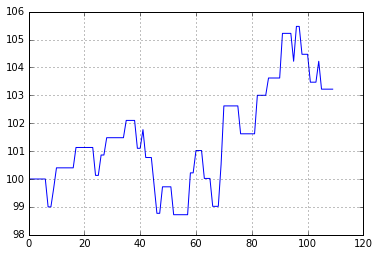

In [48]:
bankroll = 100.0
trace = []
for i in test_report.index:
    stake = 1.0
    # bet on home win
    if test_report.loc[i, 'Predicted Outcome'] == 'A':
        bankroll -= stake
        # win the bet
        if test_report.loc[i, 'True Outcome'] == test_report.loc[i, 'Predicted Outcome']:
            bankroll += stake*test_report.loc[i, test_report.loc[i, 'True Outcome']]
        # lost the bet
        else:
            pass
    trace.append(round(bankroll, 2))

plt.plot(range(len(test_report.index)), trace)
plt.grid()

In [ ]:
# Vanderplas learning curve

from sklearn.datasets import load_boston
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Ridge, Lasso

def plot_learning_curve(model, err_func=explained_variance_score, N=300, n_runs=10, n_sizes=50, ylim=None):
    sizes = np.linspace(5, N, n_sizes).astype(int)
    train_err = np.zeros((n_runs, n_sizes))
    validation_err = np.zeros((n_runs, n_sizes))
    for i in range(n_runs):
        for j, size in enumerate(sizes):
            xtrain, xtest, ytrain, ytest = train_test_split(
                X, y, train_size=size, random_state=i)
            # Train on only the first `size` points
            model.fit(xtrain, ytrain)
            validation_err[i, j] = err_func(ytest, model.predict(xtest))
            train_err[i, j] = err_func(ytrain, model.predict(xtrain))

    plt.plot(sizes, validation_err.mean(axis=0), lw=2, label='validation')
    plt.plot(sizes, train_err.mean(axis=0), lw=2, label='training')

    plt.xlabel('traning set size')
    plt.ylabel(err_func.__name__.replace('_', ' '))
    
    plt.grid(True)
    
    plt.legend(loc=0)
    
    plt.xlim(0, N-1)
    
    if ylim:
        plt.ylim(ylim)


X = load_boston().data
y = load_boston().target
plt.figure(figsize=(10, 8))
for i, model in enumerate([Lasso(0.01), Ridge(0.06)]):
    plt.subplot(221 + i)
    plot_learning_curve(model, ylim=(0, 1))
    plt.title(model.__class__.__name__)
    
    plt.subplot(223 + i)
    plot_learning_curve(model, err_func=mean_squared_error, ylim=(0, 8000))
